In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData, inspect, cast, Date

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base() 

# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Stations = Base.classes.station

inspector = inspect(engine)
columns  = inspector.get_columns("Measurement")

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

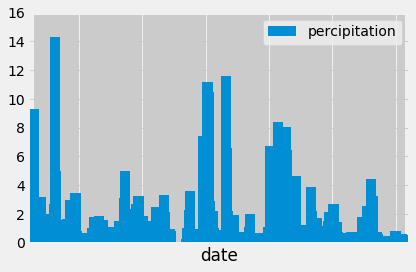

In [97]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
for row in lastDate: 
    date = dt.datetime.strptime(row, "%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
        func.sum(Measurement.prcp)]

data = session.query(*sel).\
     filter(func.strftime("%Y-%m-%d", Measurement.date) >= str((date - dt.timedelta(days=365)))).\
     group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(data, columns = ("date", "percipitation"))
prcp_df = prcp_df.set_index('date')

# Sort the dataframe by date
prcp_df.sort_values(by='date', inplace=True)
prcp_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.bar(width=10)
plt.tick_params(axis='x', labelbottom=False)
plt.ylim([0,16])
plt.tight_layout()
plt.savefig("")
plt.show()


In [45]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,percipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [11]:
# Design a query to show how many stations are available in this dataset?
session.query(Stations).count()

9

In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Stations.station, 
       func.count(Measurement.station)]

rankedStations = session.query(*sel).filter(Measurement.station == Stations.station).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for row in rankedStations: 
    print(f"Station ID: {row.station} Record Count: {row[1]}")

print(type(rankedStations))
bestId = rankedStations[0][0]

print(bestId)


Station ID: USC00519281 Record Count: 2772
Station ID: USC00519397 Record Count: 2724
Station ID: USC00513117 Record Count: 2709
Station ID: USC00519523 Record Count: 2669
Station ID: USC00516128 Record Count: 2612
Station ID: USC00514830 Record Count: 2202
Station ID: USC00511918 Record Count: 1979
Station ID: USC00517948 Record Count: 1372
Station ID: USC00518838 Record Count: 511
<class 'list'>
USC00519281


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [Stations.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)
      ]
    
session.query(*sel).\
    filter(Measurement.station == Stations.station).\
    filter(Stations.station == bestId).all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

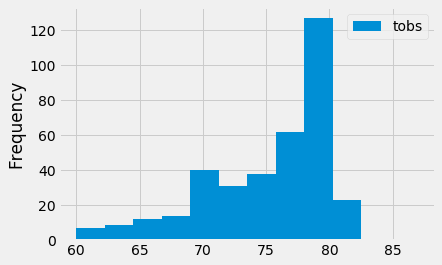

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

data = session.query(Measurement.tobs).\
     filter(func.strftime("%Y-%m-%d", Measurement.date) >= str((date - dt.timedelta(days=365)))).\
     filter(Stations.station == bestId).\
     group_by(Measurement.date).all()

bestStation_df = pd.DataFrame(data)
bestStation_df.plot.hist(bins=12)
plt.tight_layout
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [48]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startDate = (date - dt.timedelta(days=730))
endDate = (date - dt.timedelta(days=365))

data = calc_temps(startDate, endDate)
data

2015-08-24 00:00:00
2016-08-23 00:00:00


[(56.0, 74.4375, 86.0)]

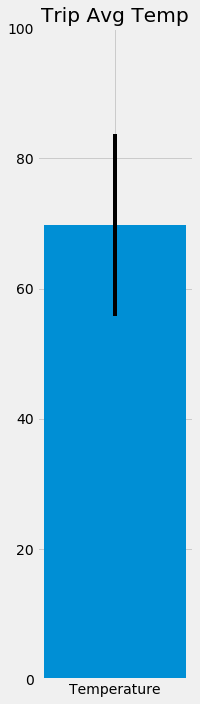

In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = data[0][0]
tavg = data[0][1]
tmax = data[0][2]

plt.figure(figsize=(3,10))
plt.bar(x="Temperature", height=tavg, yerr=(tmax-tmin))
plt.ylim([0,100])
plt.title('Trip Avg Temp')
plt.tight_layout()


In [63]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = {Stations.station,
       Stations.name,
       Stations.latitude, 
       Stations.longitude, 
       Stations.elevation,
       func.sum(Measurement.tobs)}

data = session.query(*sel).filter(Measurement.station == Stations.station).\
            filter(Measurement.date >= startDate).\
            filter(Measurement.date <= endDate).\
            group_by(Stations.station).\
            order_by(func.sum(Measurement.tobs).desc())

for row in data: 
    print(row)


('USC00519397', -157.8168, 'WAIKIKI 717.2, HI US', 27356.0, 3.0, 21.2716)
('USC00513117', -157.8015, 'KANEOHE 838.1, HI US', 26824.0, 14.6, 21.4234)
('USC00519281', -157.84888999999998, 'WAIHEE 837.5, HI US', 26637.0, 32.9, 21.45167)
('USC00519523', -157.71139, 'WAIMANALO EXPERIMENTAL FARM, HI US', 25354.0, 19.5, 21.33556)
('USC00514830', -157.8374, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 24493.0, 7.0, 21.5213)
('USC00516128', -157.8025, 'MANOA LYON ARBO 785.2, HI US', 24027.0, 152.4, 21.3331)
('USC00517948', -157.9751, 'PEARL CITY, HI US', 15568.0, 11.9, 21.3934)
('USC00511918', -157.9992, 'HONOLULU OBSERVATORY 702.2, HI US', 2492.0, 0.9, 21.3152)
('USC00518838', -158.0111, 'UPPER WAHIAWA 874.3, HI US', 1135.0, 306.6, 21.4992)


In [82]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [140]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startDate = date 

# Use the start and end date to create a range of dates
dateList = [date - dt.timedelta(days=x) for x in range(14)]

# Stip off the year and save a list of %m-%d strings
cleanList = []
for x in dateList:
    cleanDate = x.strftime("%m-%d")
    cleanList.append(cleanDate)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for x in cleanList:
    dn = daily_normals(x)
    normals.append(dn[0])
print(normals)


[(67.0, 76.6923076923077, 87.0), (69.0, 76.47169811320755, 84.0), (67.0, 76.4, 83.0), (68.0, 76.45283018867924, 82.0), (69.0, 75.94642857142857, 85.0), (70.0, 76.92307692307692, 84.0), (69.0, 76.125, 83.0), (69.0, 76.08, 83.0), (69.0, 76.47169811320755, 83.0), (71.0, 76.77777777777777, 82.0), (71.0, 76.98245614035088, 84.0), (67.0, 76.52727272727273, 83.0), (67.0, 75.98113207547169, 82.0), (65.0, 76.42, 83.0)]


In [161]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=("tmin", "tavg", "tmax"),
                       index = [pd.date_range(start=date - dt.timedelta(days=13), end=date ,freq='D')])
trip_df

,tmin,tavg,tmax
2017-08-10,67.0,76.692308,87.0
2017-08-11,69.0,76.471698,84.0
2017-08-12,67.0,76.400000,83.0
2017-08-13,68.0,76.452830,82.0
2017-08-14,69.0,75.946429,85.0
2017-08-15,70.0,76.923077,84.0
2017-08-16,69.0,76.125000,83.0
2017-08-17,69.0,76.080000,83.0
2017-08-18,69.0,76.471698,83.0
2017-08-19,71.0,76.777778,82.0


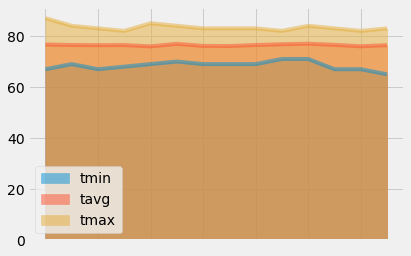

In [166]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False)
plt.tick_params(axis='x', labelbottom=False)
plt.show()
